# Time Serie

https://www.youtube.com/watch?v=vV12dGe_Fho

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

## Libraries

In [1]:
!pip install xgboost

In [2]:
%matplotlib inline

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import Normalizer 

from sklearn.metrics import silhouette_score as ss

import plotly.express as px

import itertools

from matplotlib import gridspec 

from sklearn.datasets import make_blobs

from seaborn import scatterplot as scatter

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm

import statsmodels.tsa.api as smtsa

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.stattools import adfuller

from tqdm import tqdm_notebook

from itertools import product

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.metrics import median_absolute_error, mean_squared_log_error

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd

# Read the CSV file and set the "Date" column as the index
raia = pd.read_csv("RADL3.SA.csv", usecols=["Date", "Close"], index_col="Date", parse_dates=True)

# Display the DataFrame with the index set to "Date" and only the "Close" column
print(raia)


                Close
Date                 
2012-01-02   2.538461
2012-01-03   2.576923
2012-01-04   2.576923
2012-01-05   2.557692
2012-01-06   2.548076
...               ...
2023-12-21  29.020000
2023-12-22  28.889999
2023-12-26  29.420000
2023-12-27  29.160000
2023-12-28  29.400000

[2977 rows x 1 columns]


In [4]:
raia.plot(style = ".")

<Axes: xlabel='Date'>

## Train Test Split

In [5]:
train = raia.loc[raia.index < "01-01-2021"]
test = raia.loc[raia.index >= "01-01-2021"]

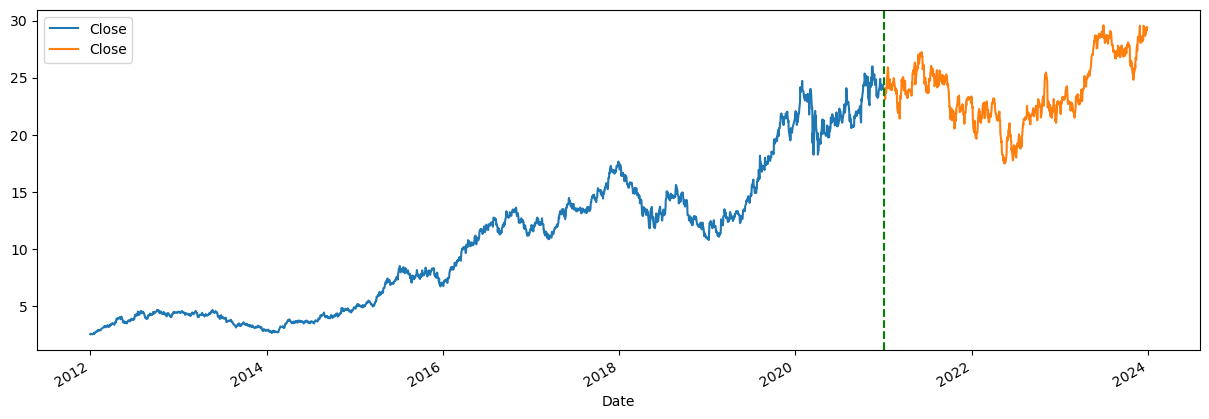

In [6]:
fig, ax = plt.subplots(figsize = (15, 5))

train.plot(ax = ax, label = "Training Set")
test.plot(ax = ax, label = "Test Set")

ax.axvline("01-01-2021", color = "green", ls = "--")

plt.show()

<Axes: xlabel='Date'>

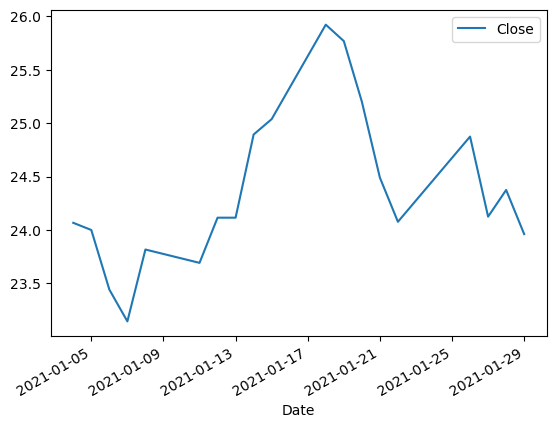

In [7]:
raia.loc[(raia.index > "01-01-2021") & (raia.index < "02-01-2021")].plot()

## Feature Creation

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

In [8]:
def create_features(raia):
    """
    Create time series features 
    """
    raia = raia.copy()
    raia["quarter"] = raia.index.quarter
    raia["month"] = raia.index.month
    raia["year"] = raia.index.year

    return(raia)

In [9]:
raia = create_features(raia)

In [10]:
train = create_features(train)
test = create_features(test)


FEATURES = ['quarter', 'month', 'year']
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Visualise our features / target relationship

In [11]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "year", y = "Close")

<Axes: xlabel='year', ylabel='Close'>

<Axes: xlabel='month', ylabel='Close'>

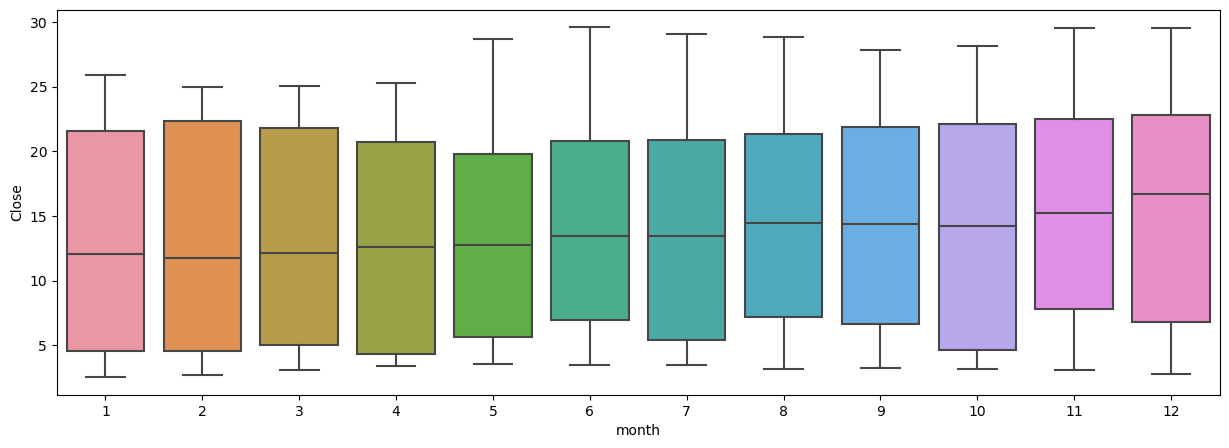

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(data = raia, x = "month", y = "Close")

## Create our model

In [13]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                      learning_rate = 0.001)
reg.fit(X_train, y_train,
       eval_set = [(X_train, y_train), (X_test, y_test)],
       verbose = 100)

[0]	validation_0-rmse:6.30738	validation_1-rmse:13.57619
[100]	validation_0-rmse:5.72285	validation_1-rmse:12.49618
[200]	validation_0-rmse:5.19473	validation_1-rmse:11.52286
[300]	validation_0-rmse:4.71759	validation_1-rmse:10.64845
[400]	validation_0-rmse:4.28639	validation_1-rmse:9.86573
[500]	validation_0-rmse:3.89709	validation_1-rmse:9.16281
[600]	validation_0-rmse:3.54560	validation_1-rmse:8.53260
[700]	validation_0-rmse:3.22820	validation_1-rmse:7.96782
[800]	validation_0-rmse:2.94187	validation_1-rmse:7.46239
[900]	validation_0-rmse:2.68344	validation_1-rmse:7.01036
[999]	validation_0-rmse:2.45286	validation_1-rmse:6.61047


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [14]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_, 
                 columns = ["importance"])

In [15]:
fi

importance
quarter    0.012580
month      0.017943
year       0.969477

<Axes: >

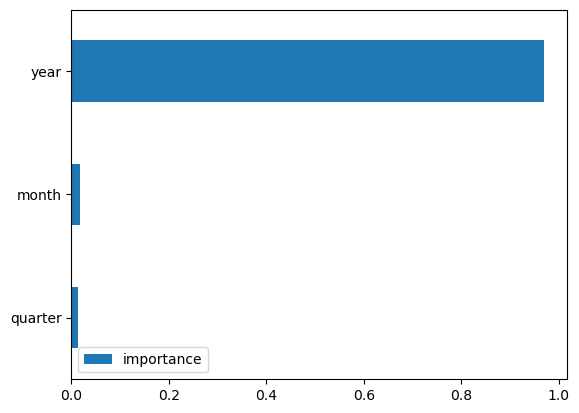

In [16]:
fi.sort_values("importance").plot(kind = "barh")

## Forecast on Test

In [17]:
test["prediction"] = reg.predict(X_test)

In [18]:
raia.merge(test[["prediction"]], how = "left", left_index = True, right_index = True)

Close  quarter  month  year  prediction
Date                                                   
2012-01-02   2.538461        1      1  2012         NaN
2012-01-03   2.576923        1      1  2012         NaN
2012-01-04   2.576923        1      1  2012         NaN
2012-01-05   2.557692        1      1  2012         NaN
2012-01-06   2.548076        1      1  2012         NaN
...               ...      ...    ...   ...         ...
2023-12-21  29.020000        4     12  2023   19.163269
2023-12-22  28.889999        4     12  2023   19.163269
2023-12-26  29.420000        4     12  2023   19.163269
2023-12-27  29.160000        4     12  2023   19.163269
2023-12-28  29.400000        4     12  2023   19.163269

[2977 rows x 5 columns]

KeyError: 'prediction'

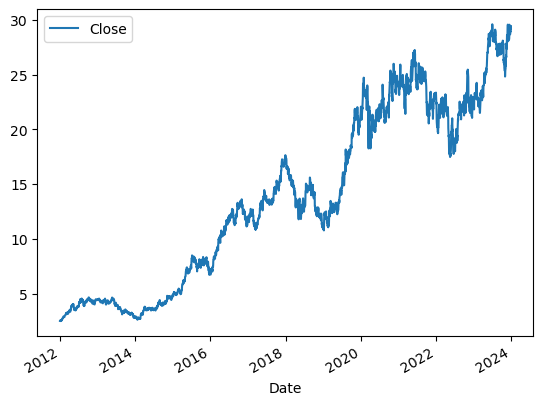

In [20]:
ax = raia[["Close"]].plot()
raia["prediction"].plot(ax = ax, style = ".")